# Radial distribution function 

The Radial Distribution Function, denoted as $g(r)$, is an analytical tool for discerning the structural ordering of particles across various states of matter. To calculate RDF in isotropic homogeneous system, one can first define the average pair density of particles. Pair density is the particle density within a differential spherical shell at a radius $r$ from a reference particle:
\begin{equation*}
\rho(r) = \left\langle \frac{dn}{4\pi r^2 dr} \right\rangle,
\end{equation*}
where $dn$ represents the incremental count of particles within this infinitesimal volume element $4\pi r^2 dr$.

For normalization, this pair density is compared to the average density $\rho=N/V$, which is the pair density of an ideal gas, to yield the RDF:
\begin{equation*}
g(r) = \frac{\rho(r)}{\rho}.
\end{equation*}

<div style="text-align: center;">
    <img src="rdf_calculate.png" width="300" height="290">
</div>

We use freud python package to calculate RDF

In [1]:
import gsd.hoomd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import progs.analysis as analysis
import progs.drawing as drawing
import numpy as np
from scipy import stats
import freud
import matplotlib as mpl
import matplotlib.colors as mcolors

for rigid model at different temperatures

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2351799/2278655531.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


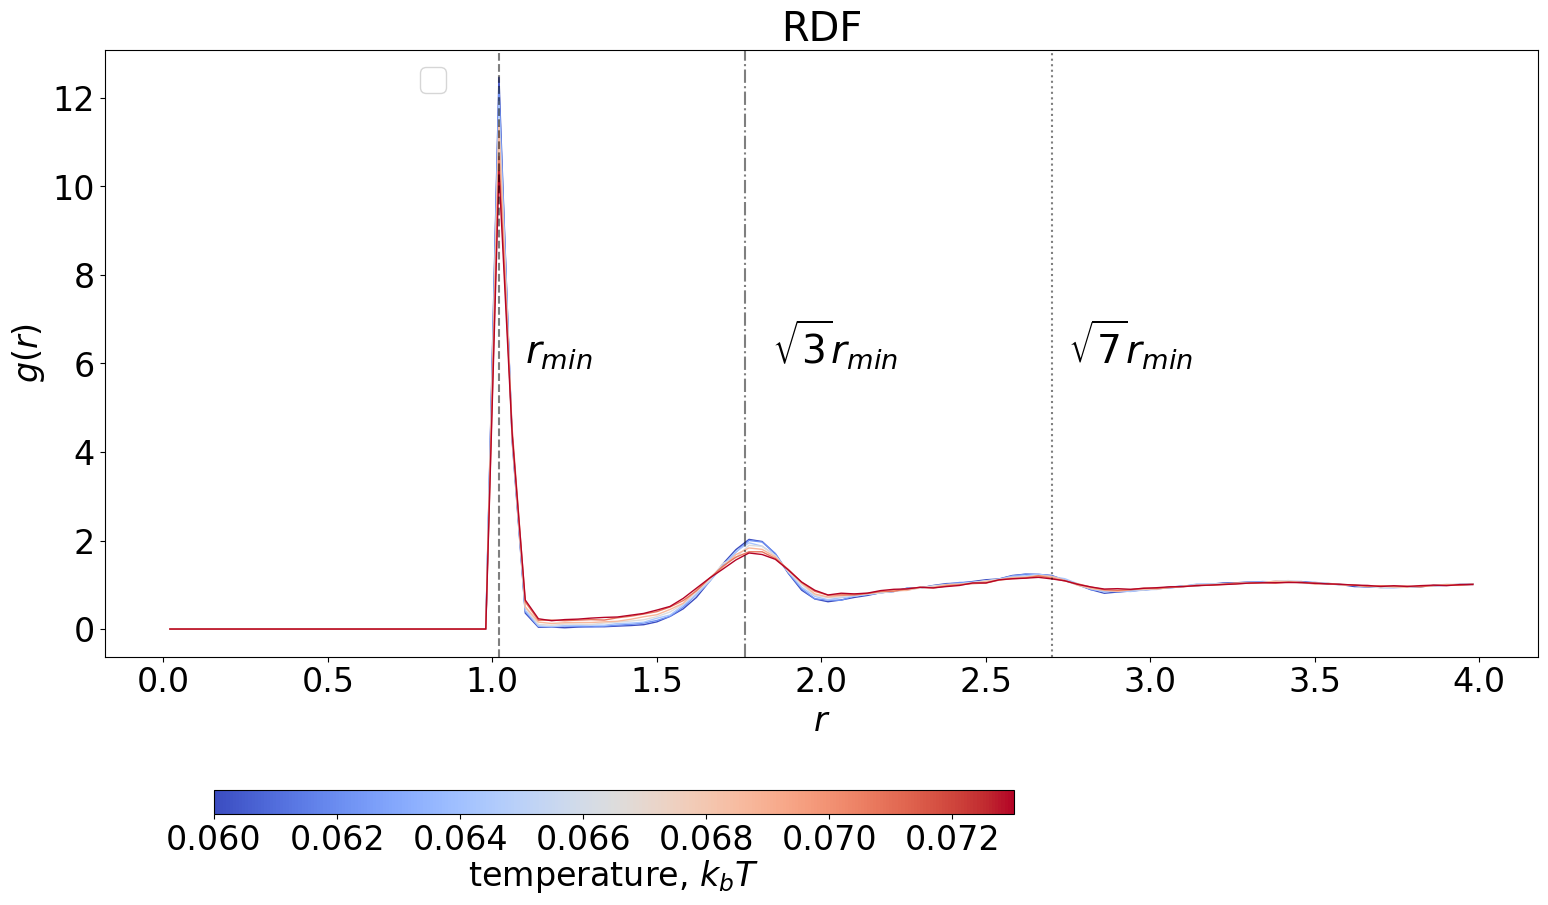

In [13]:
# create a figure
mpl.rcParams['font.size'] = 24
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True, sharex=True)

#add colorbar
colors = [mpl.cm.coolwarm(i) for i in np.linspace(0, 1, 13)]
norm = mpl.colors.Normalize(vmin=0.06, vmax=0.073)
sm = mpl.pyplot.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.15, -0.05, 0.5, 0.03]) 
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'temperature, $k_bT$', rotation=0, labelpad=1)

#load data
trajs = [gsd.hoomd.open('/share/scratch1/alena.taskina01/md/hoomd4/3patches/rigid/kT'+str(np.round(0.06+i*0.002, 3))+'/msd_8_5.gsd') for i in range(7)]

#calculate and plot rdf
#save data to lists xs and ys for further analysis
xs = []
ys =  []
for i, traj in enumerate(trajs):
    #range sets the number of frames to average over
    for j in range(1):
        particles = analysis.get_cores_coords(traj[-1-j])
        box = traj[-1].configuration.box
        rdf = freud.density.RDF(bins=100, r_max=4)
        rdf.compute(system=(box, particles))
    rdf.plot(ax=ax)
    ax.lines[-1].set_color(colors[2*i])
    ax.lines[-1].set_linewidth(1)     
    x, y = ax.lines[-1].get_data()
    xs.append(x)
    ys.append(y)

#plot the expected positions of the peaks
ax.axvline(50/49, linestyle='--', color='k', alpha=0.5)
ax.axvline((50/49)*np.sqrt(3), linestyle='-.', color='k', alpha=0.5)
ax.axvline((50/49)*(np.sqrt(7)), linestyle=':', color='k', alpha=0.5)
ax.annotate(r'$r_{min}$', xy=(1.1, 6), rotation=0, color='k', fontsize=28)
ax.annotate(r'$\sqrt{3} r_{min}$', xy=(1.85, 6), rotation=0, color='k', fontsize=28)
ax.annotate(r'$\sqrt{7} r_{min}$', xy=(2.75, 6), rotation=0, color='k', fontsize=28)

ax.legend(bbox_to_anchor=(0.25,1))
fig.tight_layout()

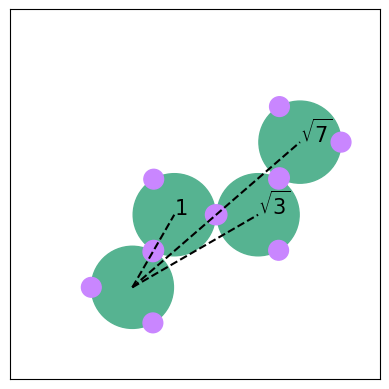

In [4]:
r = 50/49
fig, ax1 = plt.subplots()
drawing.draw_particle((0,0), 0, ax1, fill=True)
drawing.draw_particle((r,0), 180, ax1, fill=True)
drawing.draw_particle((r+r*np.cos(np.deg2rad(60)), r*np.sin(np.deg2rad(60))), 0, ax1, fill=True)
drawing.draw_particle((-r*np.cos(np.deg2rad(60)), -r*np.sin(np.deg2rad(60))), 60, ax1, fill=True)

drawing.draw_line((-r*np.cos(np.deg2rad(60)), -r*np.sin(np.deg2rad(60))),  (0,0), '1', ax1)
drawing.draw_line((-r*np.cos(np.deg2rad(60)), -r*np.sin(np.deg2rad(60))),  (r,0), r'$\sqrt{3}$', ax1,  '-.')
drawing.draw_line((-r*np.cos(np.deg2rad(60)), -r*np.sin(np.deg2rad(60))),  (r+r*np.cos(np.deg2rad(60)), r*np.sin(np.deg2rad(60))), r'$\sqrt{7}$', ax1, ':')


ax1.set_xlim(-2, 2.5)
ax1.set_ylim(-2, 2.5)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xticks([])
ax1.set_yticks([])
plt.show()

The first peak of the RDF signifies the shell of the first nearest neighbors around a reference particle. The number of particles residing in this first coordination shell is quantified by the coordination number. This number therefore gives important information about material structure.To calculate the coordination number $N_c$, one can integrate the RDF, $g(r)$, from zero to the first local minimum $min_1$ following the first peak. This integration is performed over the volume encompassed by this region:
\begin{equation*}
N_c = \int_0^{min_1} g(r) 4\pi r^2 \, dr.
\end{equation*}

In [10]:
#defines the surface area of a sphere with radius r
def s_sphere(r):
    return 4*np.pi*r**2

#defines the volume of a sphere with radius r
def v_sphere(r):
    return (4/3)*np.pi*(r**3)

#integrates the function f (array) over the range of volumes with radiuses r (array)  
def integrate(r, f):
    return np.sum(f*s_sphere(r)*(r[1]-r[0]))

#find the minima of the function f (array) and return the indices of the minima
def find_minima_indices(f):
    first_derivative = np.diff(f)
    sign_changes = np.diff(np.sign(first_derivative))
    # Local minima will be where the change of sign derivative is positive (from negative to positive)
    minima_indices = np.where(sign_changes > 0)[0] + 1  # +1 due to the nature of diff reducing array size
    return minima_indices

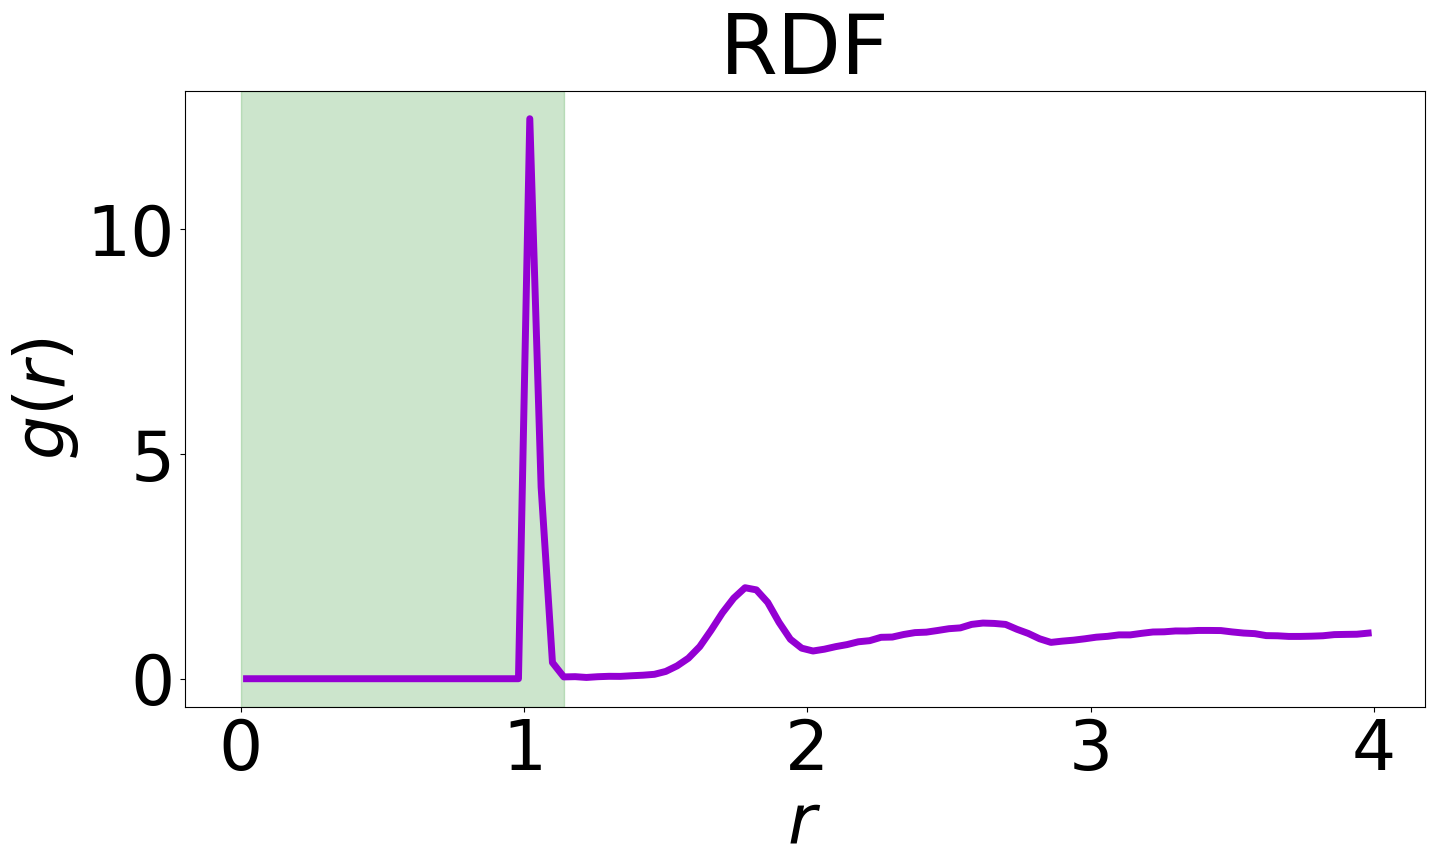

In [11]:
mpl.rcParams['font.size'] = 50
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True, sharex=True)

traj = gsd.hoomd.open('/share/scratch1/alena.taskina01/md/hoomd4/3patches/rigid/kT0.06/msd_8_5.gsd')

for j in range(1):
    particles = analysis.get_cores_coords(traj[-1-j*10])
    box = traj[-1].configuration.box
    rdf = freud.density.RDF(bins=100, r_max=4)
    rdf.compute(system=(box, particles))
rdf.plot(ax=ax)
ax.lines[-1].set_color('darkviolet')
ax.lines[-1].set_linewidth(5)     
x, y = ax.lines[-1].get_data()

r_min = x[find_minima_indices(y)[1]]
ax.axvspan(0, r_min, color='green', alpha=0.2)

In [14]:
# calculate the coordination number
coord_num = {}
for i, traj in enumerate(trajs):
    rho = 10648/trajs[i][0].log['md/compute/ThermodynamicQuantities/volume'][0] #density, number of particles/volume
    num = integrate(xs[i][:find_minima_indices(ys[i])[1]+1], ys[i][:find_minima_indices(ys[i])[1]+1])*rho
    coord_num[0.06+i*0.002] = num

Slope: -17.318038219425553, Intercept: 3.9569601655213917
Correlation Coefficient: -0.9828666220662023
P-value: 7.312458535227658e-05 (Statistical significance)
Standard Error: 1.4524037225783335


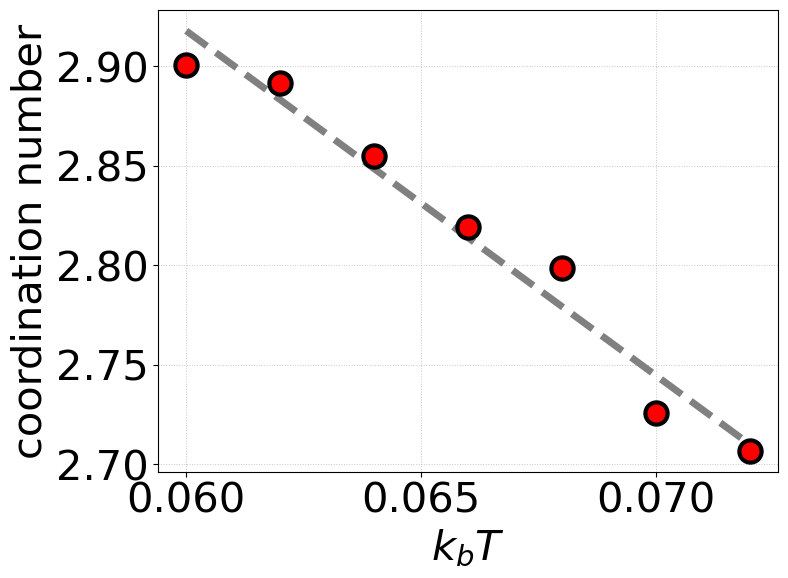

In [16]:
# create a figure
mpl.rcParams['font.size'] = 30
f, axs = plt.subplots(1, 1, figsize = (8,6))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.xlabel(r'$k_bT$')
plt.ylabel(r'coordination number')

# extract the data
x = np.array(list(coord_num.keys()))
y = np.array(list(coord_num.values()))

#plot the linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, slope * x + intercept, linestyle='--', color='grey', linewidth=5)
print(f"Slope: {slope}, Intercept: {intercept}")
print(f"Correlation Coefficient: {r_value}")
print(f"P-value: {p_value} (Statistical significance)")
print(f"Standard Error: {std_err}")

#plot the data
plt.plot(x, y, 'o', markersize=18, color='k')
plt.plot(x, y, 'o', markersize=12, color='r')

for flexible model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2351799/1008542731.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


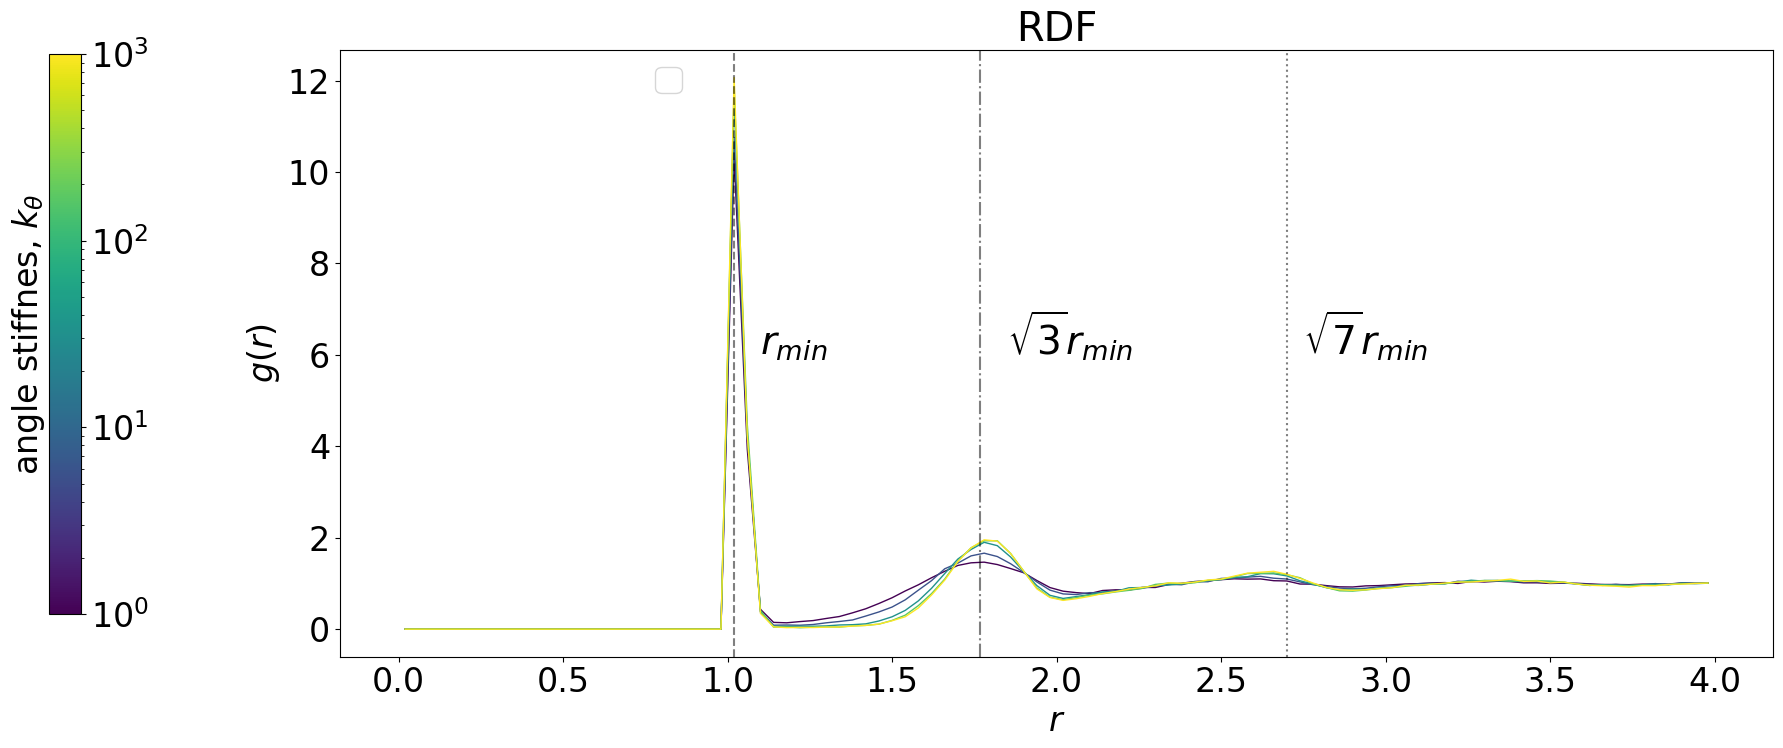

In [20]:
# create a figure
mpl.rcParams['font.size'] = 24
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True, sharex=True)

#add colorbar
colors = plt.cm.viridis(np.linspace(0, 1, 5))
norm = mcolors.LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar_ax = fig.add_axes([-0.1, 0.2, 0.02, 0.7]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'angle stiffnes, $k_\theta$', rotation=90, labelpad=-100)

coord_num = {'1':{}, '2':{}, '10':{}, '100':{}, '1000':{}}
q=0 #counter for colors
for k in [1,2,10, 100, 1000]:
    trajs = [gsd.hoomd.open('/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k'+ str(k) + '/' +str(np.round(0.06+i*0.002, 3))+'/msd_8_5.gsd') for i in range(6)]
    xs = []
    ys =  []
    for i, traj in enumerate(trajs):
        for j in range(1): #range sets the number of frames to average over
            particles = analysis.get_cores_coords(traj[-1-j])
            box = traj[-1].configuration.box
            rdf = freud.density.RDF(bins=100, r_max=4)
            rdf.compute(system=(box, particles))
        if i==0: #plot only the rdf for kT=0.06
            rdf.plot(ax=ax)
            ax.lines[-1].set_color(colors[q])
            ax.lines[-1].set_linewidth(1) 
        else:
            rdf.plot(ax=ax)
            ax.lines[-1].set_color(colors[q])
            ax.lines[-1].set_linewidth(0)     
        x, y = ax.lines[-1].get_data()
        xs.append(x)
        ys.append(y)

        # calculate coordination number
        rho = 10648/trajs[i][0].log['md/compute/ThermodynamicQuantities/volume'][0]
        num = integrate(xs[i][:find_minima_indices(ys[i])[1]+1], ys[i][:find_minima_indices(ys[i])[1]+1])*rho
        coord_num[str(k)][0.06+i*0.002] = num

    q+=1

#plot the expected positions of the peaks
ax.axvline(50/49, linestyle='--', color='k', alpha=0.5)
ax.axvline((50/49)*np.sqrt(3), linestyle='-.', color='k', alpha=0.5)
ax.axvline((50/49)*(np.sqrt(7)), linestyle=':', color='k', alpha=0.5)
ax.annotate(r'$r_{min}$', xy=(1.1, 6), rotation=0, color='k', fontsize=28)
ax.annotate(r'$\sqrt{3} r_{min}$', xy=(1.85, 6), rotation=0, color='k', fontsize=28)
ax.annotate(r'$\sqrt{7} r_{min}$', xy=(2.75, 6), rotation=0, color='k', fontsize=28)

ax.legend(bbox_to_anchor=(0.25,1))

fig.tight_layout()

/tmp/ipykernel_2351799/25429760.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


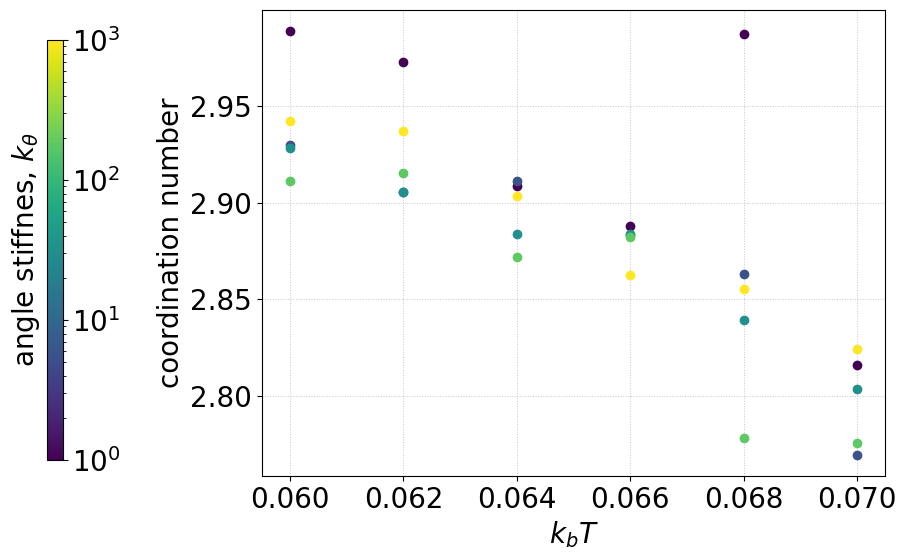

In [21]:
# create a figure
mpl.rcParams['font.size'] = 20
f, axs = plt.subplots(1, 1, figsize = (8,6))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.xlabel(r'$k_bT$')
plt.ylabel(r'coordination number')
#add colorbar
colors = plt.cm.viridis(np.linspace(0, 1, 5))
norm = mcolors.LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar_ax = f.add_axes([-0.1, 0.2, 0.02, 0.7]) 
cbar = f.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'angle stiffnes, $k_\theta$', rotation=90, labelpad=-80)

#plot the data
i=0 # counter for colors
for k in [1,2,10,100,1000]:
    x = list(coord_num[str(k)].keys())
    y = list(coord_num[str(k)].values())
    plt.plot(x, y, 'o', color=colors[i])
    i+=1

f.tight_layout()